In [1]:
import pandas as pd

In [2]:
price_df=pd.read_csv('Wholesale_price_trends_20240907204403.csv')

In [3]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175282 entries, 0 to 175281
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Period start   175282 non-null  object 
 1   Period end     175282 non-null  object 
 2   Region ID      175282 non-null  object 
 3   Region         175282 non-null  object 
 4   Price ($/MWh)  175282 non-null  float64
dtypes: float64(1), object(4)
memory usage: 6.7+ MB


In [4]:
price_df.loc[:,'Period start']=pd.to_datetime(price_df.loc[:,'Period start'],format="%d/%m/%Y %H:%M:%S")
price_df=price_df.set_index('Period start')

/home/nlim/miniconda3/envs/govhack/lib/python3.12/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [5]:
demand_df=pd.read_csv('Demand_trends_20240907130430.csv')
demand_df.loc[:,'Period start']=pd.to_datetime(demand_df.loc[:,'Period start'],format="%d/%m/%Y %H:%M:%S")
demand_df=demand_df.set_index('Period start')

/home/nlim/miniconda3/envs/govhack/lib/python3.12/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [6]:
generation_df=pd.read_csv('Generation_trends_20240907170859.csv')
generation_df.loc[:,'Period start']=pd.to_datetime(generation_df.loc[:,'Period start'],format="%d/%m/%Y %H:%M:%S")
generation_df=generation_df.set_index('Period start')

/home/nlim/miniconda3/envs/govhack/lib/python3.12/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [7]:
weather_df = pd.read_csv('howick-weather-daily-extremes.csv')
weather_df.Date=pd.to_datetime(weather_df.Date)

In [8]:
weather_df=weather_df.iloc[:,[0,1,3,5,6,8,10,12,14,16,19,20,21,23,25,27]]

In [9]:
weather_df=weather_df.set_index('Date')

In [10]:
weather_df=weather_df.resample('30T').ffill()

/tmp/ipykernel_25982/3799000217.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  weather_df=weather_df.resample('30T').ffill()


In [11]:
merged_df=weather_df.join(generation_df).dropna().join(demand_df,rsuffix='_2').join(price_df,rsuffix='_3')

In [12]:
merged_df=merged_df.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,18,19,23,24,28]]

In [13]:
merged_df['day_of_year']=merged_df.index.dayofyear
merged_df['hour']=merged_df.index.hour
merged_df['minute']=merged_df.index.minute
merged_df['day_of_week']=merged_df.index.dayofweek


In [14]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175276 entries, 2014-01-01 00:00:00 to 2023-12-31 23:30:00
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HighTemperature   175276 non-null  float64
 1   LowTemperature    175276 non-null  float64
 2   AvgTemperature    175276 non-null  float64
 3   HighDewpoint      175276 non-null  float64
 4   LowDewpoint       175276 non-null  float64
 5   HighHumidity      175276 non-null  int64  
 6   LowHumidity       175276 non-null  int64  
 7   HighWindSpeed     175276 non-null  float64
 8   HighWindGust      175276 non-null  float64
 9   WindRun           175276 non-null  float64
 10  Rainfall          175276 non-null  float64
 11  HighRainRate      175276 non-null  float64
 12  HighHourlyRain    175276 non-null  float64
 13  HighPressure      175276 non-null  float64
 14  LowPressure       175276 non-null  float64
 15  Generation (GWh)  175276 non-null 

In [15]:
import tensorflow as tf
import tensorflow.keras as keras

2024-09-08 06:55:46.326715: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-08 06:55:46.337167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-08 06:55:46.346951: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-08 06:55:46.350204: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-08 06:55:46.359820: I tensorflow/core/platform/cpu_feature_guar

In [16]:
import matplotlib.pyplot as plt

In [17]:
import numpy as np

In [18]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


Direct price prediction

In [106]:
forecast_horizon=24

In [107]:

y=merged_df.iloc[:,19].shift(-forecast_horizon)
win_length = 336
batch_size = 16
num_features = len(merged_df.columns)
train_pos=int(len(merged_df)*0.8)
train_generator = TimeseriesGenerator(merged_df.to_numpy()[0:train_pos],y.to_numpy()[0:train_pos],length=win_length,sampling_rate=1,batch_size=batch_size)
test_generator = TimeseriesGenerator(merged_df.to_numpy()[train_pos-win_length:-forecast_horizon],y.to_numpy()[train_pos-win_length:-forecast_horizon],length=win_length,sampling_rate=1,batch_size=batch_size)


In [128]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(win_length,num_features)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(1))
model.compile(loss='MSE',optimizer=keras.optimizers.Adam(learning_rate=0.00001))

In [129]:
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_15 (Flatten)            │ (None, 8064)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 8064)           │        32,256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │         8,065 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,321 (157.50 KB)

 Trainable params: 24,193 (94.50 KB)

 Non-trainable params: 16,128 (63.00 KB)

In [130]:
model.fit(train_generator,epochs=50,validation_data=test_generator)

Epoch 1/50
8743/8743 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 16552.9160 - val_loss: 92963.2109
Epoch 2/50
8743/8743 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 10788.6221 - val_loss: 45404.8203
Epoch 3/50
8743/8743 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 8385.6670 - val_loss: 39342.5977
Epoch 4/50
8743/8743 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 6803.2920 - val_loss: 541435.6875
Epoch 5/50
8743/8743 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 7239.1592 - val_loss: 31131.0703
Epoch 6/50
8743/8743 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 6215.5942 - val_loss: 406135.1250
Epoch 7/50
8743/8743 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 6215.8198 - val_loss: 1776052.6250
Epoch 8/50
8743/8743 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 7326.0981 - val_loss: 117306.0078
Epoch 9/50
8743/8743 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 8842.9980 - val_loss: 81371.0234
Epoch 10/50
8743/8743 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 8142.4761 - val_loss: 57173.5859
Epoch 11/50
8743/8743 ━━━━━━━━━━

In [133]:
price_pred=model.predict(test_generator)

2190/2190 ━━━━━━━━━━━━━━━━━━━━ 2s 979us/step


(0.0, 800.0)

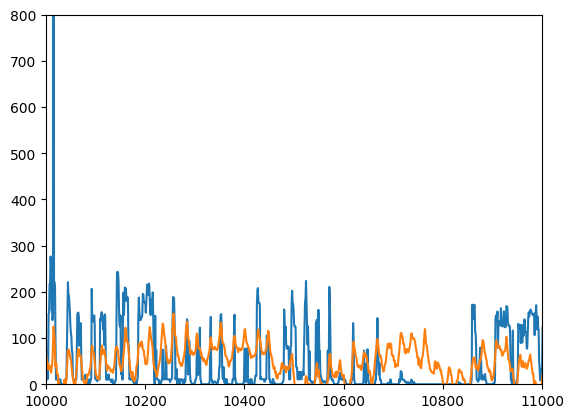

In [146]:
plt.plot(y.to_numpy()[train_pos-win_length:-2])
plt.plot(price_pred)
plt.xlim([10000,11000])
plt.ylim([0, 800])


Demand Predictioin

In [26]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175276 entries, 2014-01-01 00:00:00 to 2023-12-31 23:30:00
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HighTemperature   175276 non-null  float64
 1   LowTemperature    175276 non-null  float64
 2   AvgTemperature    175276 non-null  float64
 3   HighDewpoint      175276 non-null  float64
 4   LowDewpoint       175276 non-null  float64
 5   HighHumidity      175276 non-null  int64  
 6   LowHumidity       175276 non-null  int64  
 7   HighWindSpeed     175276 non-null  float64
 8   HighWindGust      175276 non-null  float64
 9   WindRun           175276 non-null  float64
 10  Rainfall          175276 non-null  float64
 11  HighRainRate      175276 non-null  float64
 12  HighHourlyRain    175276 non-null  float64
 13  HighPressure      175276 non-null  float64
 14  LowPressure       175276 non-null  float64
 15  Generation (GWh)  175276 non-null 

In [89]:

y=merged_df.iloc[:,17].shift(-forecast_horizon)
win_length = 336
batch_size = 256
num_features = len(merged_df.columns)
train_pos=int(len(merged_df)*0.8)
train_generator = TimeseriesGenerator(merged_df.to_numpy()[0:train_pos],y.to_numpy()[0:train_pos],length=win_length,sampling_rate=1,batch_size=batch_size)
test_generator = TimeseriesGenerator(merged_df.to_numpy()[train_pos-win_length:-forecast_horizon],y.to_numpy()[train_pos-win_length:-forecast_horizon],length=win_length,sampling_rate=1,batch_size=batch_size)


In [90]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(win_length,num_features)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(4,activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1,activation='relu'))
model.compile(loss='MSE',optimizer=keras.optimizers.Adam(learning_rate=0.00003))

In [91]:
model.fit(train_generator,epochs=50,validation_data=test_generator)

Epoch 1/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 3.2471 - val_loss: 1.4741
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.2335 - val_loss: 0.8689
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1.9855 - val_loss: 0.9162
Epoch 4/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.8148 - val_loss: 0.5736
Epoch 5/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.6765 - val_loss: 0.5854
Epoch 6/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.5193 - val_loss: 1.8150
Epoch 7/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.4169 - val_loss: 1.4179
Epoch 8/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.3319 - val_loss: 0.2603
Epoch 9/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.2253 - val_loss: 0.2893
Epoch 10/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.1775 - val_loss: 0.4606
Epoch 11/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.1038 - val_loss: 0.1920
Epoch 12/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/ste

In [92]:
demand_pred=model.predict(test_generator)

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


(1000.0, 2000.0)

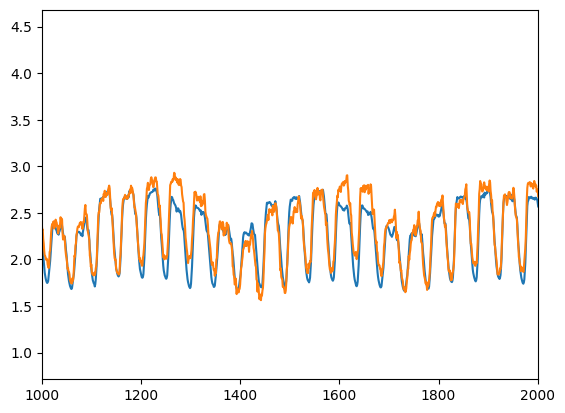

In [98]:
plt.plot(y.to_numpy()[train_pos-win_length:-2])
plt.plot(demand_pred)
plt.xlim([1000,2000])

Generation Prediction

In [99]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(win_length,num_features)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(4,activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1,activation='relu'))
model.compile(loss='MSE',optimizer=keras.optimizers.Adam(learning_rate=0.00003))

In [100]:

y=merged_df.iloc[:,15].shift(-forecast_horizon)
win_length = 336
batch_size = 256
num_features = len(merged_df.columns)
train_pos=int(len(merged_df)*0.8)
train_generator = TimeseriesGenerator(merged_df.to_numpy()[0:train_pos],y.to_numpy()[0:train_pos],length=win_length,sampling_rate=1,batch_size=batch_size)
test_generator = TimeseriesGenerator(merged_df.to_numpy()[train_pos-win_length:-forecast_horizon],y.to_numpy()[train_pos-win_length:-forecast_horizon],length=win_length,sampling_rate=1,batch_size=batch_size)

In [101]:
model.fit(train_generator,epochs=50,validation_data=test_generator)

Epoch 1/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 4.0083 - val_loss: 1.4296
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.0038 - val_loss: 0.9567
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.6706 - val_loss: 0.7891
Epoch 4/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.5364 - val_loss: 0.5655
Epoch 5/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.4628 - val_loss: 0.4977
Epoch 6/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.3644 - val_loss: 0.4179
Epoch 7/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.3034 - val_loss: 0.3597
Epoch 8/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.2357 - val_loss: 0.3329
Epoch 9/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.2093 - val_loss: 0.2759
Epoch 10/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.1734 - val_loss: 0.3008
Epoch 11/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.0848 - val_loss: 0.2827
Epoch 12/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/st

In [102]:
gen_pred=model.predict(test_generator)

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


(1000.0, 2000.0)

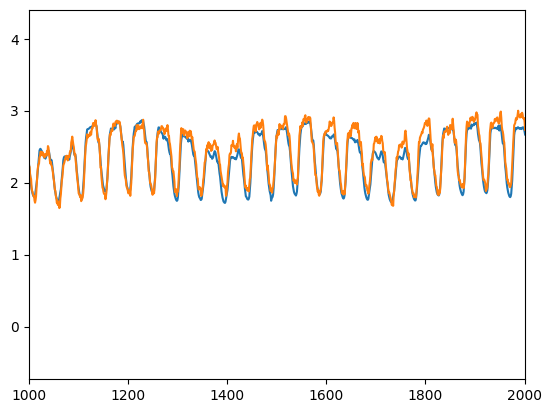

In [105]:
plt.plot(y.to_numpy()[train_pos-win_length:-2])
plt.plot(gen_pred)
plt.xlim([1000,2000])